In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df_old = pd.read_csv("WFH-785.csv")

# Basic info and first few rows
print(df_old.info())
print(df_old.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Gender     785 non-null    int64
 1   Age        785 non-null    int64
 2   Education  785 non-null    int64
 3   WorkExper  785 non-null    int64
 4   Position   785 non-null    int64
 5   WorkField  785 non-null    int64
 6   WFHDay     785 non-null    int64
 7   WFHMems    785 non-null    int64
 8   NoMems     785 non-null    int64
 9   NoKids     785 non-null    int64
 10  WFHP       785 non-null    int64
 11  FWC        785 non-null    int64
 12  SE         785 non-null    int64
 13  WE         785 non-null    int64
dtypes: int64(14)
memory usage: 86.0 KB
None
   Gender  Age  Education  WorkExper  Position  WorkField  WFHDay  WFHMems  \
0       2    4          5          3         3          4       2        1   
1       2    4          4          4         2          2       2        1   
2       

In [158]:
print(df_old['WFHP'].value_counts().sort_index())

WFHP
1      7
2     56
3    331
4    318
5     73
Name: count, dtype: int64


In [160]:
duplicates1 = df_old[df_old.duplicated()]

print(f"Number of duplicate rows:{duplicates1.shape[0]}")
print(duplicates1)

Number of duplicate rows:9
     Gender  Age  Education  WorkExper  Position  WorkField  WFHDay  WFHMems  \
455       2    3          3          3         3          4       3        1   
504       1    2          1          2         3          1       3        1   
598       2    2          1          2         3          1       3        1   
611       2    2          3          3         2          3       2        1   
700       2    1          3          2         3          4       3        1   
734       1    2          3          4         3          1       3        1   
751       1    2          1          2         3          1       3        1   
768       2    1          2          2         3          4       1        2   
781       2    2          3          2         3          4       3        1   

     NoMems  NoKids  WFHP  FWC  SE  WE  
455       3       4     4    2   5   5  
504       6       4     4    3   4   4  
598       3       3     3    4   3   3  
611     

In [162]:
df = df_old

In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Step 1: Split features and target
X = df.drop(columns=['WFHP'])
y = df['WFHP']

# Step 2: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Step 3: Combine training features and target
df_train = pd.concat([X_train, y_train], axis=1)

# Step 4: Identify underrepresented scores in the training set
minority_scores = [1.0, 2.0, 5.0]
df_minority = df_train[df_train['WFHP'].isin(minority_scores)]

# Step 5: Define number of synthetic samples per minority group (target oversample sizes)
n_samples_per_group = {
    1.0: 150,
    2.0: 130,
    5.0: 100,
}

synthetic_samples = []

# Step 6: Generate synthetic samples via Gaussian interpolation
for score in minority_scores:
    group = df_minority[df_minority['WFHP'] == score]
    X_group = group.drop(columns=['WFHP']).values
    y_group = group['WFHP'].values

    k = min(5, len(X_group))  # Ensure we have enough neighbors
    nn = NearestNeighbors(n_neighbors=k).fit(X_group)

    for _ in range(n_samples_per_group[score]):
        # Randomly select a sample from the minority group
        idx = np.random.randint(0, len(X_group))
        x_seed = X_group[idx]
        y_seed = y_group[idx]

        # Find the nearest neighbors
        neighbors = nn.kneighbors([x_seed], return_distance=False)[0]
        neighbor_idx = np.random.choice(neighbors)
        x_neighbor = X_group[neighbor_idx]
        y_neighbor = y_group[neighbor_idx]

        # Apply Gaussian noise to interpolation factor (alpha)
        alpha = np.random.normal(loc=0.5, scale=0.2)  # Gaussian noise with slightly wider spread
        alpha = np.clip(alpha, 0, 1)  # Ensure alpha is between 0 and 1

        # Interpolate between the sample and its neighbor
        x_synth = x_seed + alpha * (x_neighbor - x_seed)
        y_synth = y_seed + alpha * (y_neighbor - y_seed)

        # Ensure the target (y_synth) is a valid class (round to nearest valid WFHP score)
        y_synth_rounded = np.clip(round(y_synth), 1, 5)

        # Append the synthetic sample to the list
        synthetic_row = list(x_synth) + [y_synth_rounded]
        synthetic_samples.append(synthetic_row)

# Step 7: Combine synthetic data into DataFrame
columns = list(X.columns) + ['WFHP']
df_synthetic = pd.DataFrame(synthetic_samples, columns=columns)

# Step 8: Merge with original training data
df_train_augmented = pd.concat([df_train, df_synthetic], ignore_index=True)

# Step 9: Remove duplicate rows (both original and synthetic duplicates)
df_train_augmented_no_duplicates = df_train_augmented.drop_duplicates(subset=X.columns.tolist() + ['WFHP'], keep=False)

# Step 10: Add back original duplicates (if necessary)
df_train_augmented_final = pd.concat([df_train_augmented_no_duplicates, df_train[df_train.duplicated(subset=X.columns.tolist() + ['WFHP'], keep=False)]], ignore_index=True)

# Step 11: Create final full dataset with test data
df_test = pd.concat([X_test, y_test], axis=1)
df_augmented = pd.concat([df_train_augmented_final, df_test], ignore_index=True)

# Step 12: Output information
print(f"Original training dataset size: {len(df_train)}")
print(f"Synthetic samples added: {len(df_synthetic)}")
print(f"Augmented training dataset size: {len(df_train_augmented_final)}")
print(f"Final dataset size (train + test): {len(df_augmented)}")
print(f"Duplicate rows in final dataset: {df_augmented.duplicated().sum()}")


Original training dataset size: 628
Synthetic samples added: 380
Augmented training dataset size: 855
Final dataset size (train + test): 1012
Duplicate rows in final dataset: 9


In [166]:
print(df_augmented['WFHP'].value_counts().sort_index())

WFHP
1    116
2    127
3    331
4    318
5    120
Name: count, dtype: int64


In [168]:
df = df_augmented

In [170]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from math import sqrt

# Features and target
X = df.drop(columns=['WFHP'])
y = df['WFHP']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [4, 5, 6, 7],
    'min_samples_leaf': [2, 3, 4]
}

# Initialize model
dt = DecisionTreeRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_

# Predict on train and test sets
y_train_pred = best_dt.predict(X_train)
y_test_pred = best_dt.predict(X_test)

# Evaluation on training data
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = sqrt(mse_train)

# Evaluation on test data
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = sqrt(mse_test)

# 5-fold CV scores on training data
mae_scores = cross_val_score(best_dt, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))
mse_scores = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Output
print("Best Hyperparameters:", grid_search.best_params_)

print("\nTraining Set Evaluation:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print("\nTest Set Evaluation:")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

print("\n5-Fold Cross-Validation on Training Set:")
print(f"Average MAE: {mae_scores.mean():.4f}")
print(f"Average MSE: {-mse_scores.mean():.4f}")
print(f"Average RMSE: {rmse_scores.mean():.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 4}

Training Set Evaluation:
MAE: 0.3826
MSE: 0.2660
RMSE: 0.5157

Test Set Evaluation:
MAE: 0.4319
MSE: 0.3452
RMSE: 0.5876

5-Fold Cross-Validation on Training Set:
Average MAE: 0.4554
Average MSE: 0.3802
Average RMSE: 0.6161


In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from math import sqrt

# Features and target
X = df.drop(columns=['WFHP'])
y = df['WFHP']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 8, 10],
    'min_samples_leaf': [2, 3, 4]
}

# Initialize model and GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on training data only
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Training metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = sqrt(mse_train)

# Test metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = sqrt(mse_test)

# Cross-validation on training set only
neg_mse_scores = cross_val_score(best_rf, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cv_mse = -np.mean(neg_mse_scores)
cv_rmse = np.mean(np.sqrt(-neg_mse_scores))  # average RMSE from each fold

# Also calculate MAE for CV
neg_mae_scores = cross_val_score(best_rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
cv_mae = -np.mean(neg_mae_scores)

# Results
print("Best Hyperparameters:", grid_search.best_params_)

print(f"\nTraining Set Evaluation:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print(f"\nTest Set Evaluation:")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

print(f"\nCross-Validation on Training Set (5-fold):")
print(f"Average MAE: {cv_mae:.4f}")
print(f"Average MSE: {cv_mse:.4f}")
print(f"Average RMSE: {cv_rmse:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Training Set Evaluation:
MAE: 0.2921
MSE: 0.1403
RMSE: 0.3746

Test Set Evaluation:
MAE: 0.4262
MSE: 0.2928
RMSE: 0.5411

Cross-Validation on Training Set (5-fold):
Average MAE: 0.4243
Average MSE: 0.2865
Average RMSE: 0.5350


In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from math import sqrt

# Features and target
X = df.drop(columns=['WFHP'])
y = df['WFHP']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [3, 4, 5]
}

# Model and GridSearch
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_gbr = grid_search.best_estimator_

# Predictions
y_train_pred = best_gbr.predict(X_train)
y_test_pred = best_gbr.predict(X_test)

# Training metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = sqrt(mse_train)

# Test metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = sqrt(mse_test)

# Cross-validation on training set
mae_scores = cross_val_score(best_gbr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
mse_scores = cross_val_score(best_gbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

cv_mae = -np.mean(mae_scores)
cv_mse = -np.mean(mse_scores)
cv_rmse = np.mean(np.sqrt(-mse_scores))

# Output
print("Best Hyperparameters:", grid_search.best_params_)

print(f"\nTraining Set Evaluation:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print(f"\nTest Set Evaluation:")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

print(f"\nCross-Validation on Training Set (5-fold):")
print(f"Average MAE: {cv_mae:.4f}")
print(f"Average MSE: {cv_mse:.4f}")
print(f"Average RMSE: {cv_rmse:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 100}

Training Set Evaluation:
MAE: 0.3275
MSE: 0.1801
RMSE: 0.4244

Test Set Evaluation:
MAE: 0.4305
MSE: 0.3061
RMSE: 0.5532

Cross-Validation on Training Set (5-fold):
Average MAE: 0.4239
Average MSE: 0.2993
Average RMSE: 0.5470


In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from math import sqrt

# Features and target
X = df.drop(columns=['WFHP'])
y = df['WFHP']

# Scale features (important for K-NN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Adjusted hyperparameter grid
param_grid = {'n_neighbors': [7, 9, 11, 13, 15],
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'p': [2]  # Euclidean distance
}

# Initialize model and GridSearch
knn = KNeighborsRegressor()
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_

# Predict
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

# Metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = sqrt(mse_train)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = sqrt(mse_test)

# Cross-validation on training set only
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv_mse_scores = cross_val_score(best_knn, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cv_mae_scores = cross_val_score(best_knn, X_train, y_train, scoring=mae_scorer, cv=5)

cv_mse = -np.mean(cv_mse_scores)
cv_rmse = np.mean(np.sqrt(-cv_mse_scores))
cv_mae = -np.mean(cv_mae_scores)

# Output
print("Best Hyperparameters:", grid_search.best_params_)

print(f"\nTraining Set Evaluation:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print(f"\nTest Set Evaluation:")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

print(f"\nCross-Validation on Training Set (5-fold):")
print(f"Average MAE: {cv_mae:.4f}")
print(f"Average MSE: {cv_mse:.4f}")
print(f"Average RMSE: {cv_rmse:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}

Training Set Evaluation:
MAE: 0.4033
MSE: 0.3079
RMSE: 0.5549

Test Set Evaluation:
MAE: 0.4792
MSE: 0.4185
RMSE: 0.6469

Cross-Validation on Training Set (5-fold):
Average MAE: 0.4895
Average MSE: 0.4446
Average RMSE: 0.6664


C:\Users\Megan\AppData\Local\Temp\ipykernel_8244\2568505240.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


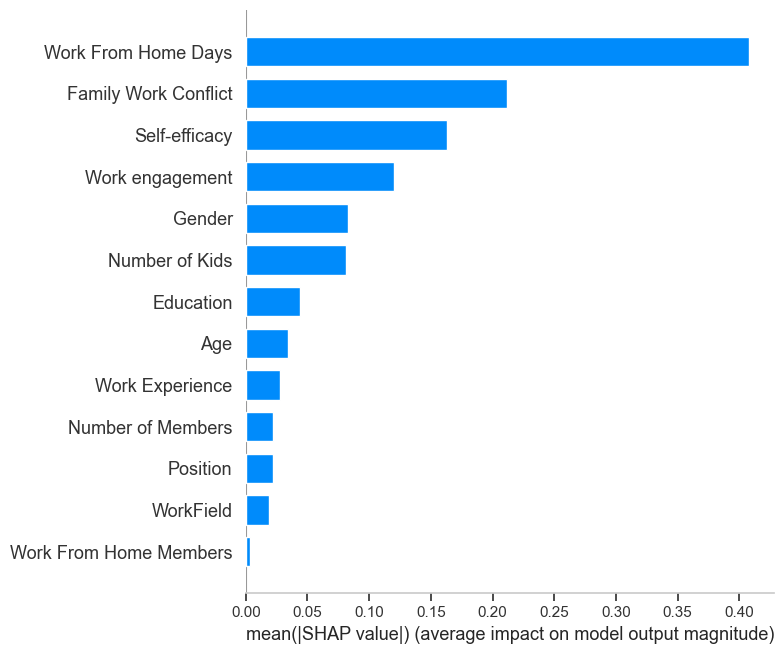

C:\Users\Megan\AppData\Local\Temp\ipykernel_8244\2568505240.py:55: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  fig = shap.summary_plot(


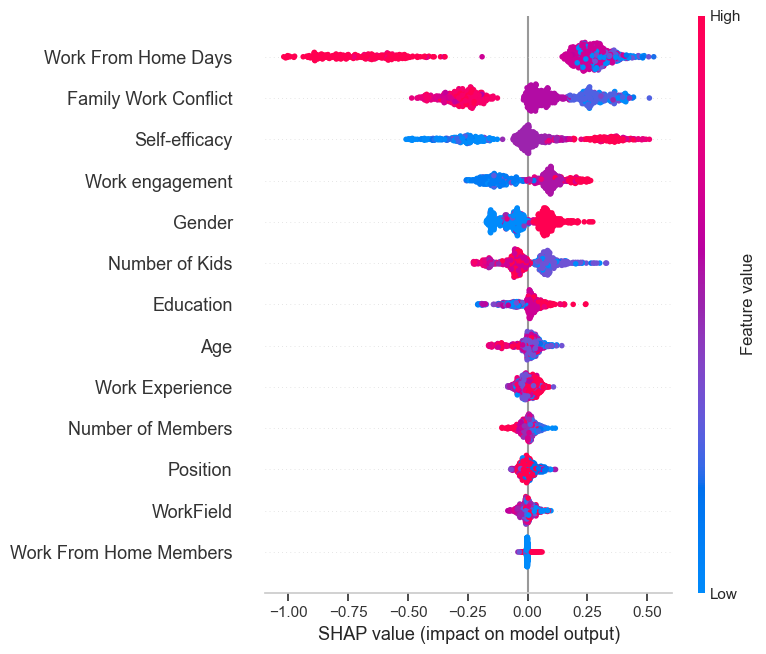

In [192]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# Split data
X = df.drop(columns=['WFHP'])
y = df['WFHP']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest model
rf_best = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42
)
rf_best.fit(X_train, y_train)

# SHAP values
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_train)

# Rename features for SHAP plots only
X_train_renamed = X_train.rename(columns={
    'WFHDay': 'Work From Home Days',
    'FWC': 'Family Work Conflict',
    'SE': 'Self-efficacy',
    'WE': 'Work engagement',
    'NoKids': 'Number of Kids',
    'NoMems': 'Number of Members',
    'WFHMems': 'Work From Home Members',
    'WorkExper': 'Work Experience'
})

# SHAP summary plot (bar)
shap.summary_plot(
    shap_values,
    X_train_renamed,
    plot_type="bar",
    show=False
)
plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()

# SHAP summary plot (beeswarm)
fig = shap.summary_plot(
    shap_values,
    X_train_renamed,
    plot_type="dot",
    show=False  # We'll call show after tweaking
)

# Remove grid from beeswarm
plt.grid(False)
plt.tight_layout()
plt.show()


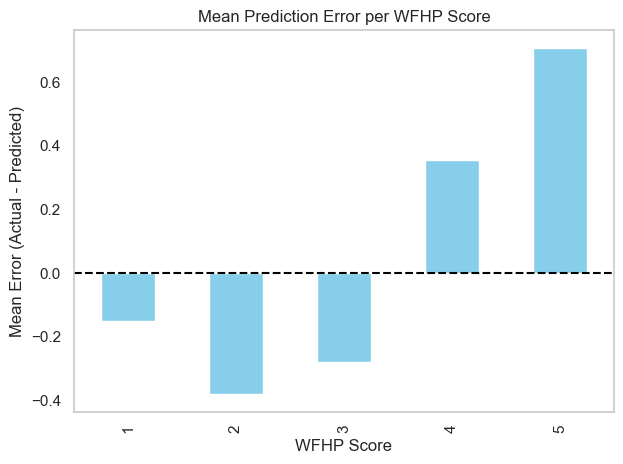

In [194]:
import pandas as pd
import matplotlib.pyplot as plt

# Get predictions and errors
y_pred = rf_best.predict(X_test)
errors = y_test - y_pred

# Combine into a single DataFrame
error_df = pd.DataFrame({
    'Actual_WFHP': y_test,
    'Predicted_WFHP': y_pred,
    'Error': errors
})

# Group by actual WFHP score
grouped_error = error_df.groupby('Actual_WFHP')['Error'].agg(['mean', 'count'])

# Plot mean error only (no error bars)
grouped_error['mean'].plot(
    kind='bar',
    color='skyblue',
    title='Mean Prediction Error per WFHP Score'
)
plt.axhline(0, color='black', linestyle='--')  # optional baseline at 0
plt.ylabel('Mean Error (Actual - Predicted)')
plt.xlabel('WFHP Score')
plt.grid(False)  # ✅ Removes grid lines
plt.tight_layout()
plt.show()


In [196]:
# Show the numerical error metrics for each WFHP score
print(grouped_error.round(3))


              mean  count
Actual_WFHP              
1           -0.150     21
2           -0.382     25
3           -0.281     72
4            0.357     63
5            0.709     22


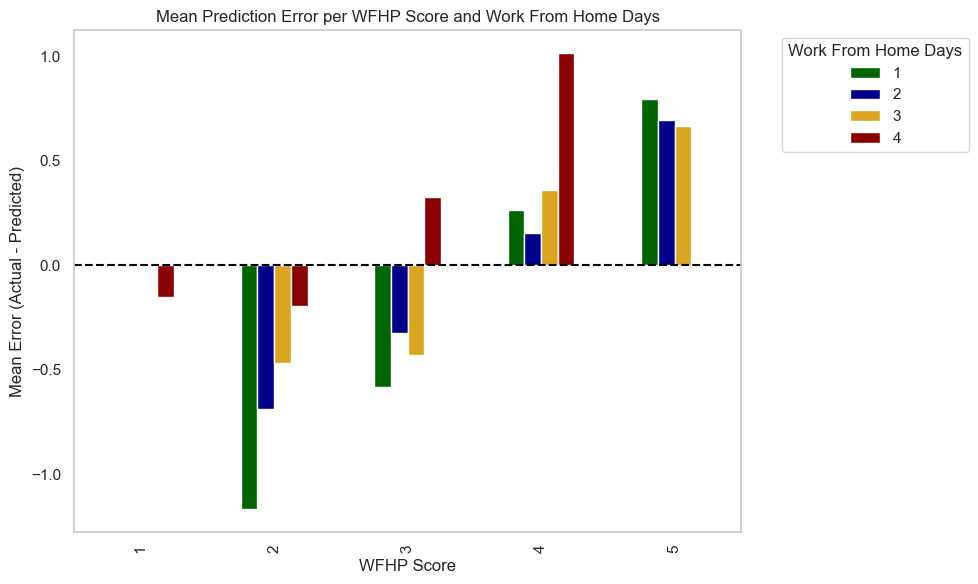

In [198]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure feature consistency with the trained model
X_test_features_only = X_test[rf_best.feature_names_in_]

# Get predictions and errors
y_pred = rf_best.predict(X_test_features_only)
errors = y_test - y_pred

# Combine into a single DataFrame (include WFHDay for grouping)
error_df = X_test.copy()
error_df['WFHDay'] = error_df['WFHDay'].astype(int)  # Convert WFHDay to integer
error_df['Actual_WFHP'] = y_test
error_df['Predicted_WFHP'] = y_pred
error_df['Error'] = errors

# Group by Actual WFHP and Remote Work Frequency
grouped_error = error_df.groupby(['Actual_WFHP', 'WFHDay'])['Error'].mean().unstack()

# Define darker custom colors
custom_colors = {
    1: 'darkgreen',
    2: 'darkblue',
    3: 'goldenrod',
    4: 'darkred'
}
color_list = [custom_colors[day] for day in grouped_error.columns]

# Plot
grouped_error.plot(
    kind='bar',
    figsize=(10, 6),
    color=color_list
)
plt.axhline(0, color='black', linestyle='--')  # baseline at 0
plt.title('Mean Prediction Error per WFHP Score and Work From Home Days')
plt.ylabel('Mean Error (Actual - Predicted)')
plt.xlabel('WFHP Score')
plt.legend(title='Work From Home Days', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)  # ✅ Removes grid lines
plt.tight_layout()
plt.show()


In [97]:
# Create the numerical table of mean errors
grouped_error_table = error_df.groupby(['Actual_WFHP', 'WFHDay'])['Error'].mean().unstack()

# Round for easier readability
grouped_error_table = grouped_error_table.round(3)

# Display the table
print(grouped_error_table)


WFHDay           1      2      3      4
Actual_WFHP                            
1              NaN    NaN    NaN -0.150
2           -1.164 -0.689 -0.468 -0.193
3           -0.580 -0.321 -0.429  0.326
4            0.263  0.155  0.359  1.014
5            0.795  0.695  0.666    NaN


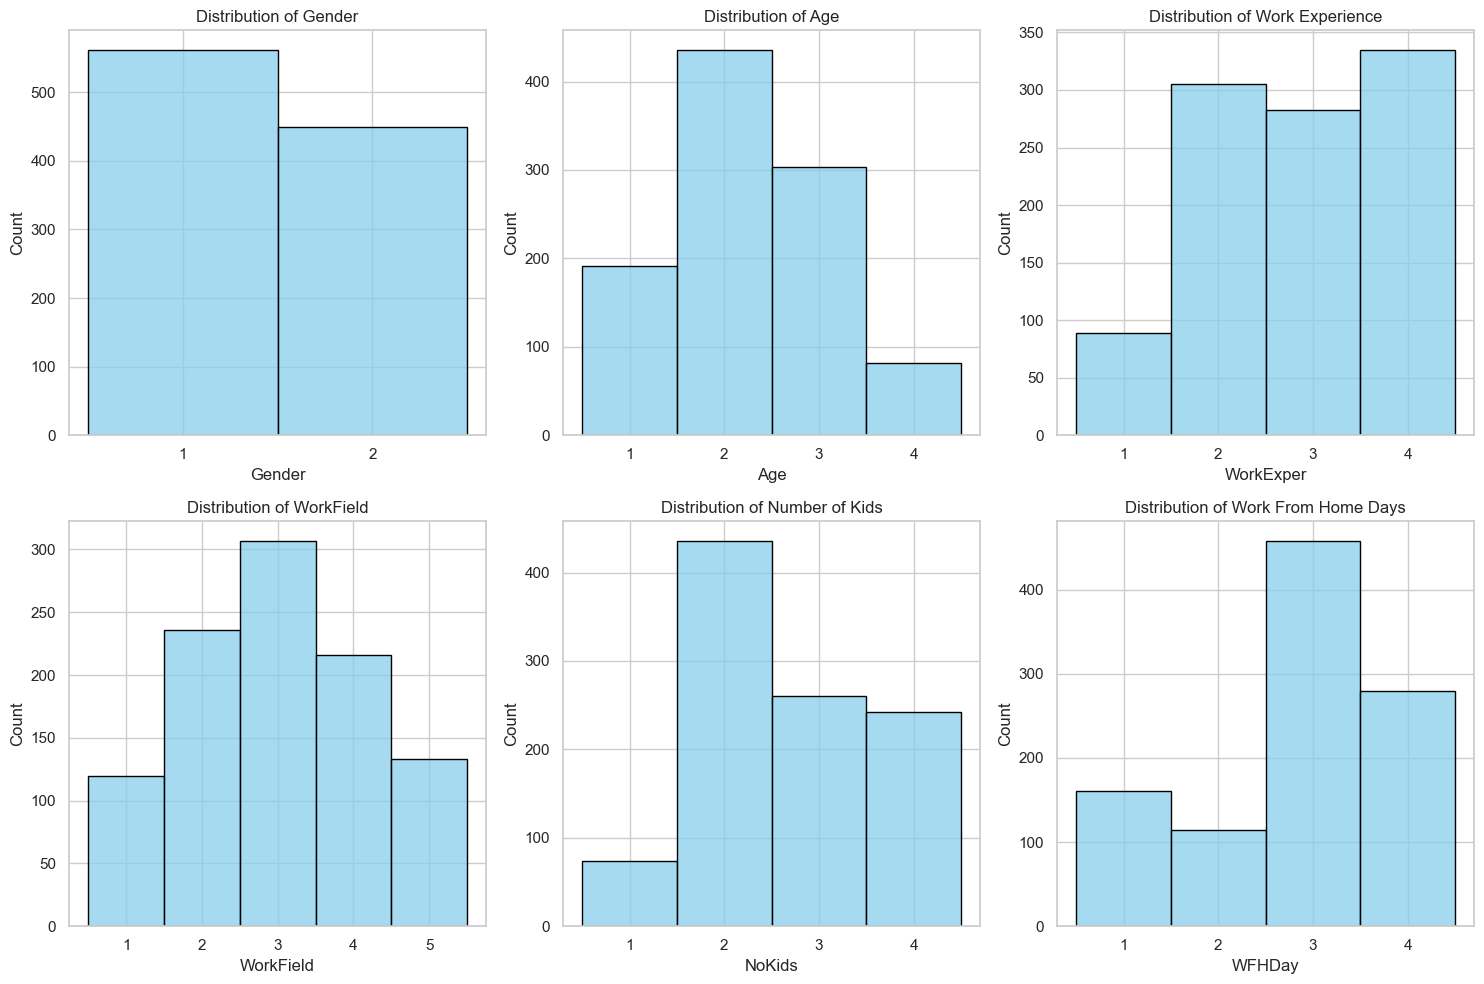

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stel dat je dataframe 'df' heet
columns_to_plot = ['Gender', 'Age', 'WorkExper', 'WorkField', 'NoKids', 'WFHDay']

# Mapping of column names to readable titles
column_titles = {
    'WorkExper': 'Work Experience',
    'NoKids': 'Number of Kids',
    'WFHDay': 'Work From Home Days'
}

# Plotstijl
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Subplots voor elke kolom
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 3, i + 1)
    data = df[col].astype(int)  # Convert to integer
    sns.histplot(data, discrete=True, color='skyblue', edgecolor='black')
    title = column_titles.get(col, col)  # Use readable title if exists, else original column name
    plt.title(f'Distribution of {title}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(sorted(data.unique()))  # Force ticks at exact values

plt.tight_layout()
plt.show()
